# **Predictive Analysis of Academic Performance Utilizing Study Habits and Prior Achievement Metrics**

In [4]:
# libraries needed in this proposal

library(repr)
library(tidyverse)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

## **Introduction**

#### **Relevant Background Information on the Topic**

The advent of the digital era and web-based learning systems has transformed education, allowing for an intricate study of student engagement. Our research, grounded in Kahraman et al.'s dataset (2013), capitalizes on these advancements by examining diverse behavioral variables.

#### **The Question We Will Try to Answer with Our Project**

Our research seeks to employ this dataset to answer two key questions: First, can we predict a student's knowledge level (UNS) based on study time for material (STG), repetition number for material (SCG), study time for related objects like prerequisites (STR), exam performance for related objects (LPR), and exam performance for material (PEG)? Second, utilizing STG, SCG, STR, and LPR, which factor correlates most strongly with PEG, the exam performance for material?

#### **The Dataset Description That Will Be Used to Answer the Question**

The core of our study are two CSV datasets: training and testing. Containing 258 and 145 entries respectively, these datasets include variables representing study time (STG), repetition number (SCG), study time for related objects (STR), exam performance for related objects (LPR), material exam performance (PEG), and user knowledge level (UNS). These resources will guide our exploration into the determinants of academic performance in a digital learning context.

## **Preliminary exploratory data analysis**

#### **Data Acquisition**

In [5]:
# download data from our group's remote repository

url <- "https://raw.githubusercontent.com/stankur/dsci-100-project/main/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.csv"

data <- read_csv(url)

data <- data |> 
        select(STG:UNS)

data

New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


#### **Initial Data Summary (Exploratory Data Analysis)**

In [6]:
# Mean values of quantitative variables
mean_data <- data |>
                mutate(STG = mean(STG),  
                       SCG = mean(SCG), 
                       STR = mean(STR),
                       LPR = mean(LPR),
                       PEG = mean(PEG)) |>
                select(STG, SCG, STR, LPR, PEG) |>
                head(1)

# Checking for missing data
na <- data |> 
            mutate(STG = is.na(STG), SCG = is.na(SCG), 
                   STR = is.na(STR), LPR = is.na(LPR), 
                   PEG = is.na(PEG), UNS = is.na(UNS)) |>
            select(STG, SCG, STR, LPR, PEG, UNS) |>
            head(1)

# Summary of 'UNS' categorical variable
uns_grouped_by_level <- group_by(data, UNS) |>
                        summarize(count = n())

# Transforming data for reporting
mean_tidy <- mean_data |>
        pivot_longer(cols = STG:PEG,
                    names_to = "Feature", values_to = "Mean") 

na_tidy <- na |>
        pivot_longer(na, cols = STG:UNS,
                    names_to = "Feature", values_to = "NA")

tidy <- data.frame("Feature" = c("STG", "SCG", "STR", "LPR", "PEG", "UNS"),
                   "Mean" = c(0.3711473, 0.3556744, 0.4680039, 0.4327132, 0.4585388, "NA"),
                   "Is.NA" = c(FALSE, FALSE, FALSE, FALSE, FALSE, FALSE)) |>
        as_tibble(tidy)

tidy
uns_grouped_by_level

Warning message in gsub(vec_paste0("^", names_prefix), "", cols):
“argument 'pattern' has length > 1 and only the first element will be used”


Feature,Mean,Is.NA
<chr>,<chr>,<lgl>
STG,0.3711473,FALSE
SCG,0.3556744,FALSE
STR,0.4680039,FALSE
LPR,0.4327132,FALSE
PEG,0.4585388,FALSE
UNS,NA,FALSE


UNS,count
<chr>,<int>
High,63
Low,83
Middle,88
very_low,24


#### **Data Visualization**

Our initial visualization consists of histograms illustrating the distribution of numerical variables (STG, SCG, STR, LPR, PEG), effectively revealing their range and frequency. Following this, we present a bar chart showcasing the distribution of categorical variable UNS (knowledge level), enabling a comparative analysis of each knowledge level category's frequency.

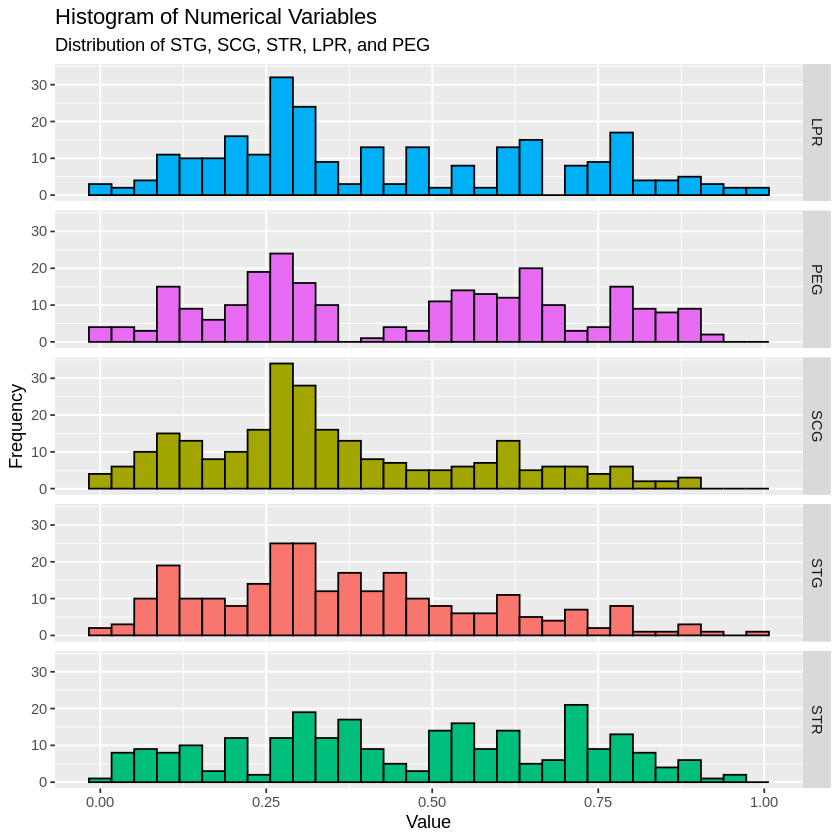

In [4]:
# Selecting numerical columns for visualization
histogrammable_data <- data |> select(STG:PEG)

# Reshaping the data from wide format to long format to facilitate visualization
histogrammable_data_pivoted <- pivot_longer(histogrammable_data, 
                                           cols= STG:PEG,
                                           names_to = "column_name",
                                           values_to ="value")

# Creating a histogram for each numerical variable
quantitative_plot <- ggplot(histogrammable_data_pivoted, aes(x = value, fill = as_factor(column_name))) +
        geom_histogram(bins = 30, color = "black") + 
        facet_grid(rows = vars(column_name)) +  
        labs(fill = "Variable", x = "Value", y = "Frequency", 
             title = "Histogram of Numerical Variables", 
             subtitle = "Distribution of STG, SCG, STR, LPR, and PEG") +
        theme(legend.position = "none") 

quantitative_plot

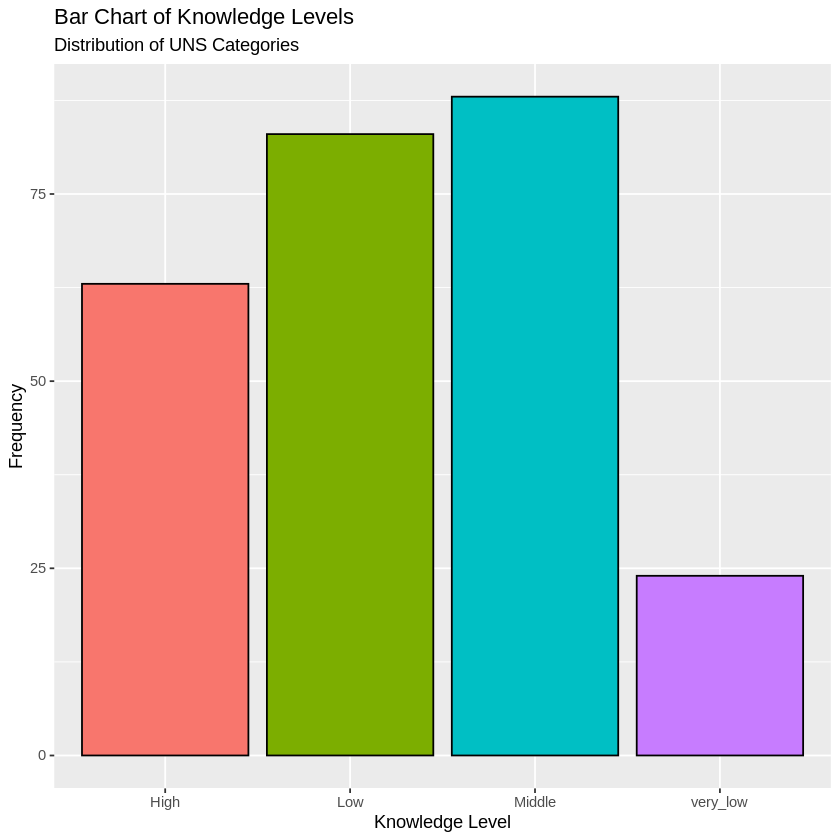

In [5]:
# Organize categories in descending order
uns_grouped_by_level <- uns_grouped_by_level |> 
                        mutate(UNS = factor(UNS, levels = names(sort(table(UNS), decreasing = TRUE))))

# Create bar chart for the categorical variable 'UNS'
uns_bar <- ggplot(uns_grouped_by_level, aes(x=UNS, y=count, fill=UNS)) + 
        geom_bar(stat="identity", color="black") + 
        labs(x="Knowledge Level", 
             y="Frequency", 
             title = "Bar Chart of Knowledge Levels", 
             subtitle = "Distribution of UNS Categories", 
             fill="Knowledge Level") +
        theme(legend.position = "none")

uns_bar

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



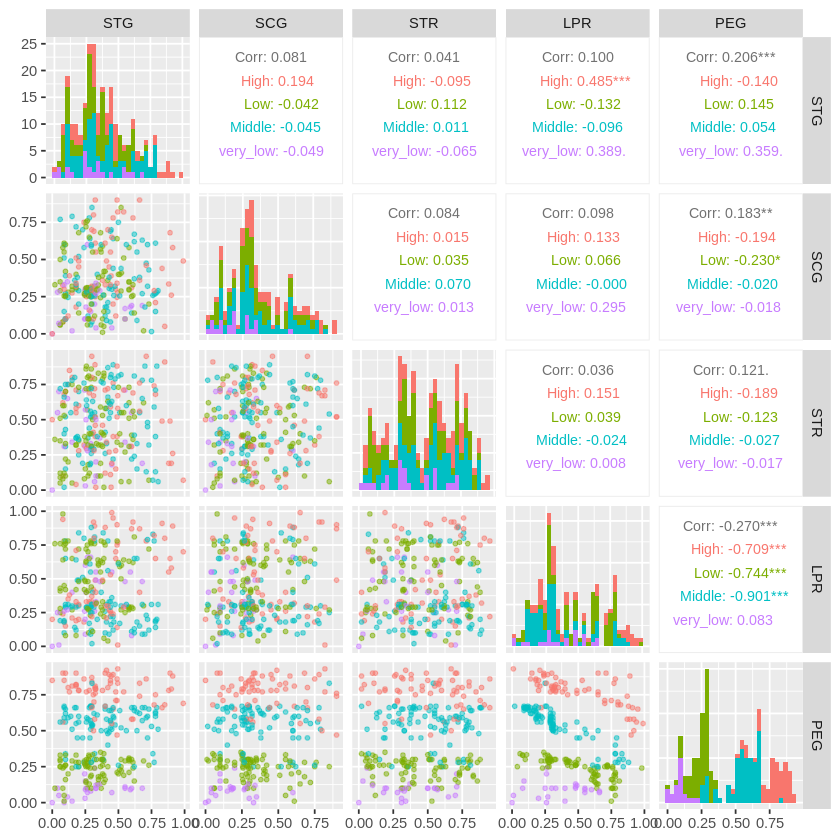

In [6]:
# Select numerical columns for visualization
data_for_ggpairs <- data |> select(STG:PEG)

# Create a pairs plot with ggpairs() function
pairs_plot <- ggpairs(data_for_ggpairs, 
                      mapping = ggplot2::aes(color = data$UNS),
                      upper = list(continuous = wrap("cor", size = 3)),  # display correlation on the upper part
                      diag = list(continuous = wrap("barDiag")),  # display histogram on the diagonal
                      lower = list(continuous = wrap("points", alpha = 0.5, size = 1)))  # display scatterplot on the lower part

# Print the plot
print(pairs_plot)

In [7]:
# Set seed for reproducibility
set.seed(9999)

# Split the data
data_split <- initial_split(data, prop = 0.75, strata = UNS)
data_train <- training(data_split)
data_test <- testing(data_split)

# Define names of the predictors
predictor_names <- c("STG", "SCG", "STR", "LPR", "PEG")

# Create an empty tibble to store the results
results <- tibble(model_string = character(), best_k = integer(), best_accuracy = numeric())

# Create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 10, strata = UNS)

# Generate power set of predictors excluding the empty set
predictor_combinations <- unlist(lapply(seq_along(predictor_names), function(x) combn(predictor_names, x, simplify = FALSE)), recursive = FALSE)

# For every combination of predictors
for (predictors in predictor_combinations) {
  # Create a model string for this combination of predictors
  model_string <- paste("UNS", "~", paste(predictors, collapse="+"))

  # Create a recipe from the model string
  data_recipe <- recipe(as.formula(model_string), data = data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

  # Tune the KNN classifier with these predictors
  tuning_results <- workflow() |>
    add_recipe(data_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = data_vfold, grid = tibble(neighbors = 1:100)) |>
    collect_metrics()

  best_k_and_accuracy <- tuning_results |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean)) |>
  slice(1)

best_k <- as.integer(best_k_and_accuracy$neighbors[1])  # convert to integer
best_accuracy <- best_k_and_accuracy$mean[1]

# Add these results to the dataframe
results <- results |> add_row(model_string = model_string, best_k = best_k, best_accuracy = best_accuracy)
}

# Sort the results by accuracy in descending order
results <- results |> arrange(desc(best_accuracy))

# Print the sorted results
print(results)

# A tibble: 31 × 3
   model_string              best_k best_accuracy
   <chr>                      <int>         <dbl>
 1 UNS ~ LPR+PEG                  1         0.953
 2 UNS ~ SCG+LPR+PEG              4         0.942
 3 UNS ~ STG+LPR+PEG              1         0.939
 4 UNS ~ STR+LPR+PEG              1         0.918
 5 UNS ~ STG+STR+LPR+PEG          4         0.885
 6 UNS ~ STG+SCG+LPR+PEG          4         0.881
 7 UNS ~ SCG+STR+LPR+PEG          1         0.870
 8 UNS ~ PEG                     21         0.860
 9 UNS ~ SCG+PEG                 17         0.843
10 UNS ~ STG+SCG+STR+LPR+PEG      1         0.839
# … with 21 more rows


[1] "Model: LPR+PEG"
[1] "Best K: 1"
[1] "Best accuracy: 0.936635846372688"


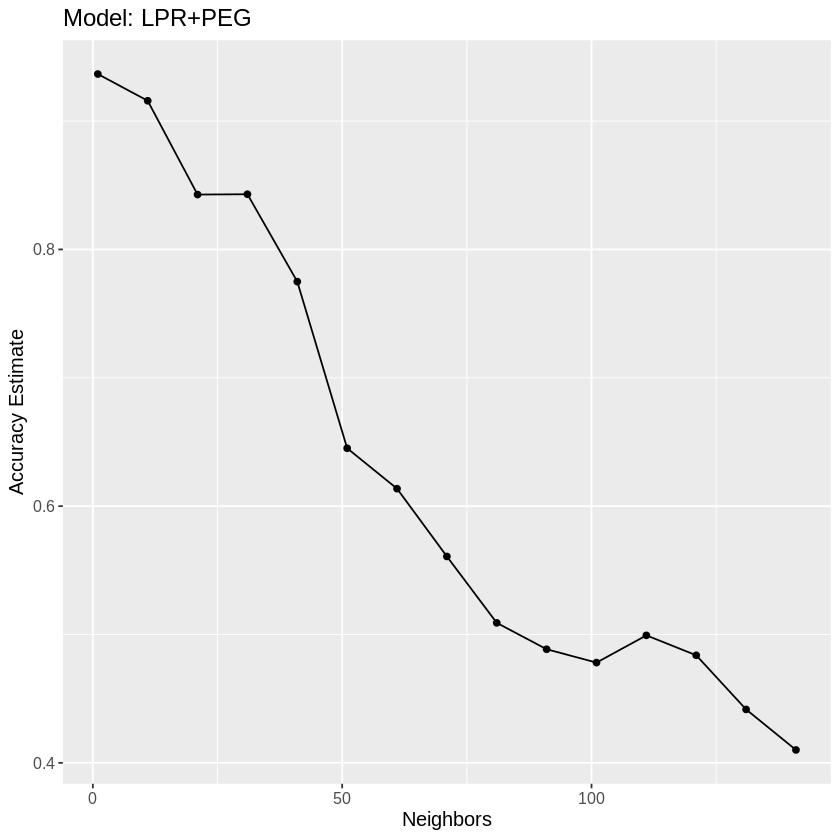

In [8]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 5, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 150, by = 10))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

! Fold07: internal:
  No observations were detected in `truth` for level(s): 'very_low'
  Computation will proceed by ignoring those levels.

! Fold10: internal:
  No observations were detected in `truth` for level(s): 'very_low'
  Computation will proceed by ignoring those levels.



[1] "Model: LPR+PEG"
[1] "Best K: 3"
[1] "Best accuracy: 0.942731829573935"


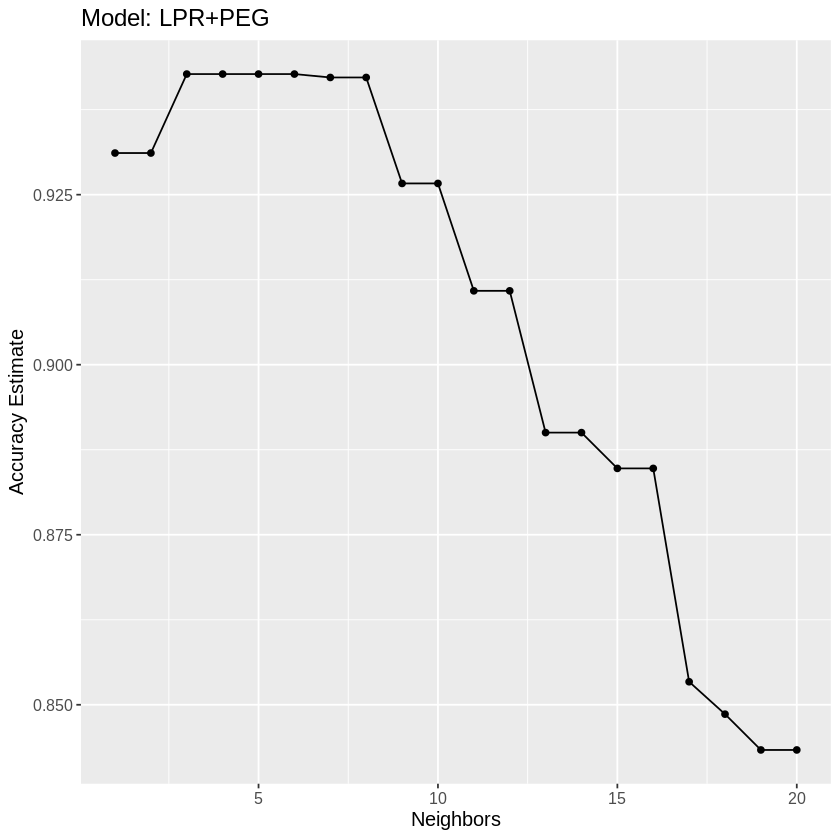

In [9]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 10, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

[1] "Model: SCG+LPR+PEG"
[1] "Best K: 1"
[1] "Best accuracy: 0.920967283072546"


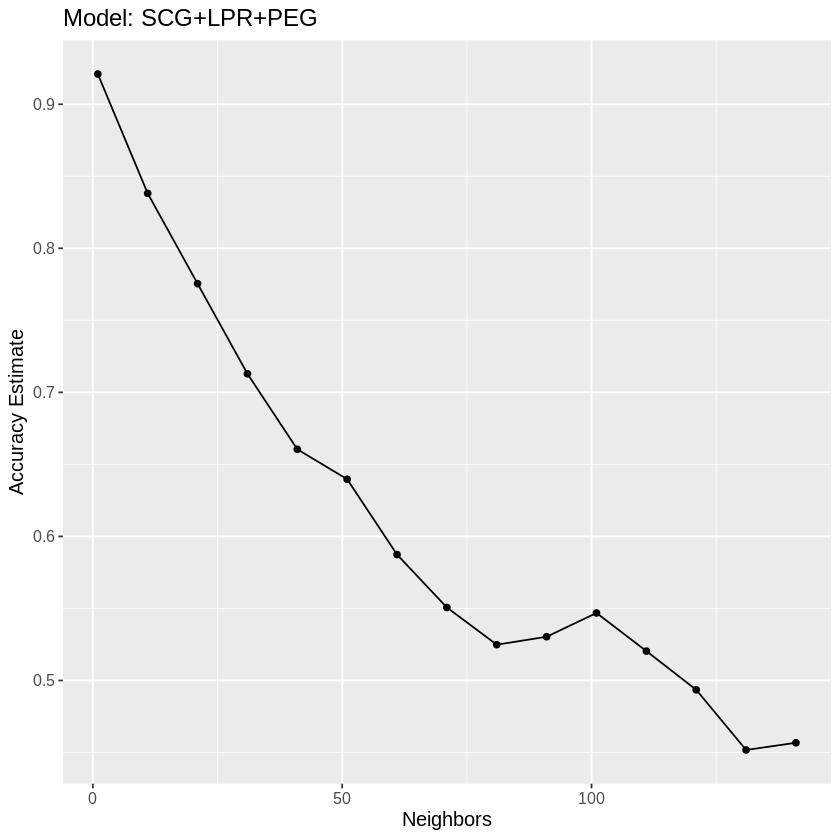

In [10]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "SCG+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 5, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 150, by = 10))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

! Fold07: internal:
  No observations were detected in `truth` for level(s): 'very_low'
  Computation will proceed by ignoring those levels.

! Fold10: internal:
  No observations were detected in `truth` for level(s): 'very_low'
  Computation will proceed by ignoring those levels.



[1] "Model: SCG+LPR+PEG"
[1] "Best K: 3"
[1] "Best accuracy: 0.931203007518797"


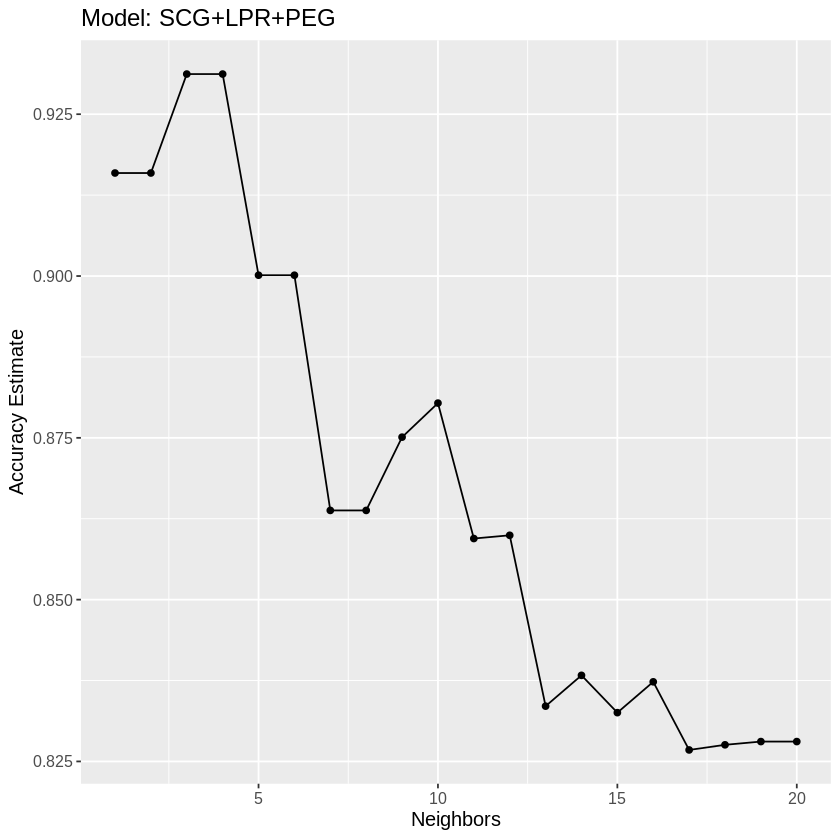

In [11]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "SCG+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 10, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

[1] "Model: STG+LPR+PEG"
[1] "Best K: 1"
[1] "Best accuracy: 0.931088193456615"


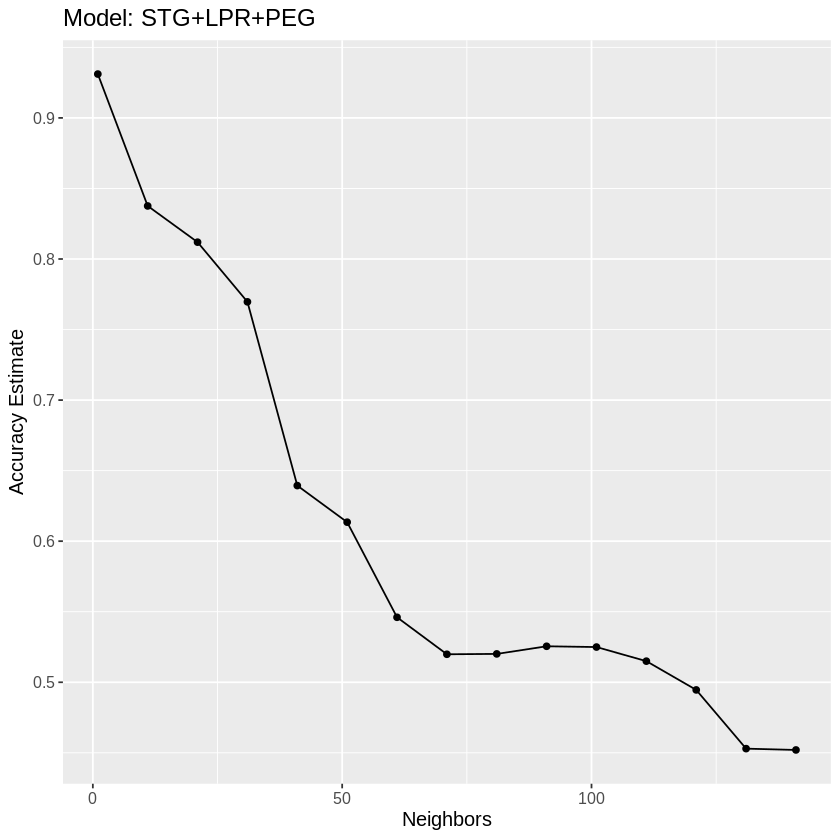

In [12]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "STG+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 5, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 150, by = 10))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

! Fold07: internal:
  No observations were detected in `truth` for level(s): 'very_low'
  Computation will proceed by ignoring those levels.

! Fold10: internal:
  No observations were detected in `truth` for level(s): 'very_low'
  Computation will proceed by ignoring those levels.



[1] "Model: STG+LPR+PEG"
[1] "Best K: 3"
[1] "Best accuracy: 0.931704260651629"


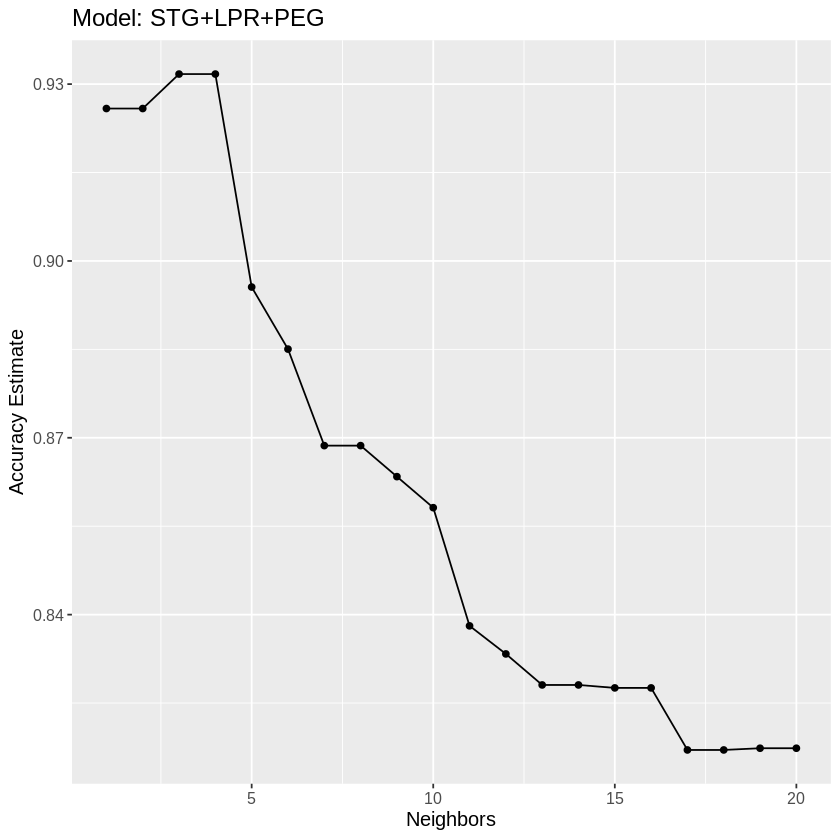

In [13]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "STG+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 10, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

[1] "Model: STR+LPR+PEG"
[1] "Best K: 1"
[1] "Best accuracy: 0.884345661450925"


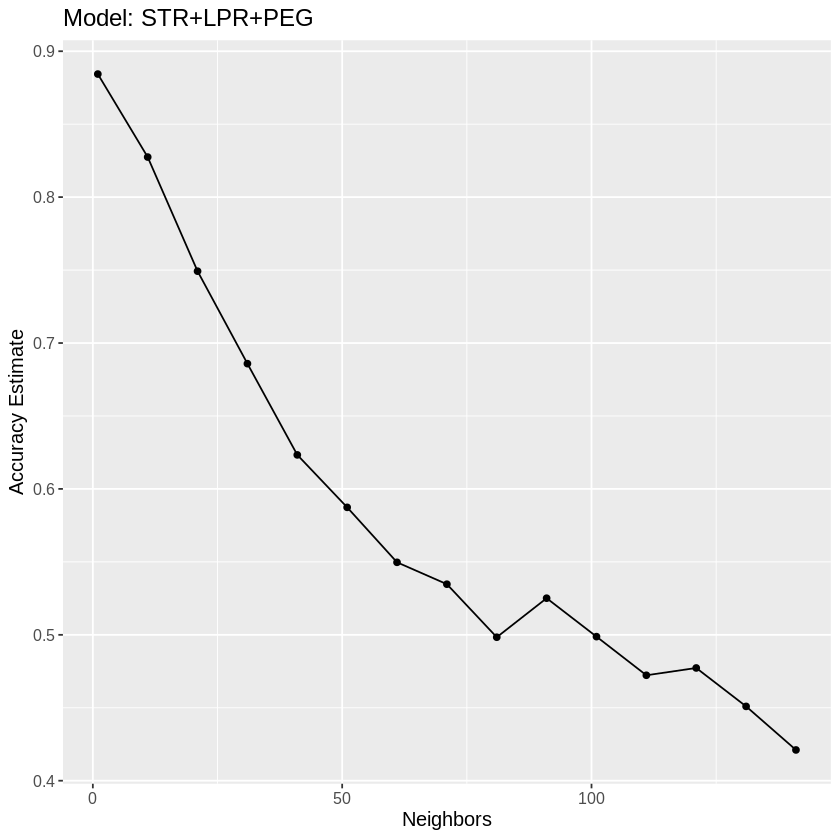

In [14]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "STR+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 5, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 150, by = 10))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

! Fold07: internal:
  No observations were detected in `truth` for level(s): 'very_low'
  Computation will proceed by ignoring those levels.

! Fold10: internal:
  No observations were detected in `truth` for level(s): 'very_low'
  Computation will proceed by ignoring those levels.



[1] "Model: STR+LPR+PEG"
[1] "Best K: 3"
[1] "Best accuracy: 0.896658312447786"


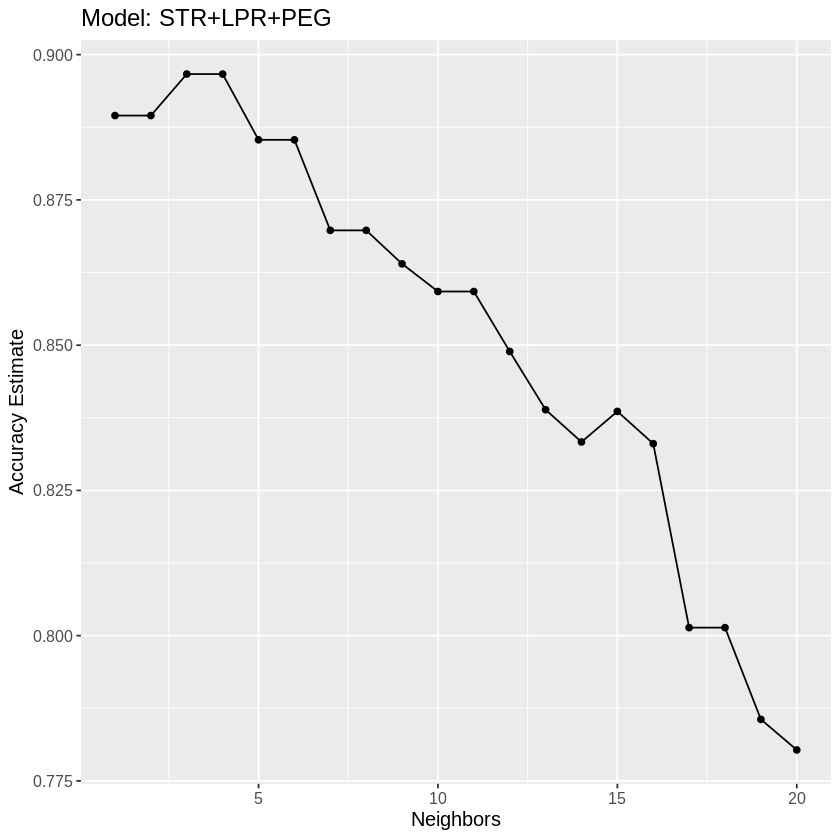

In [15]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "STR+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 10, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

[1] "Model: STG+STR+LPR+PEG"
[1] "Best K: 1"
[1] "Best accuracy: 0.863798008534851"


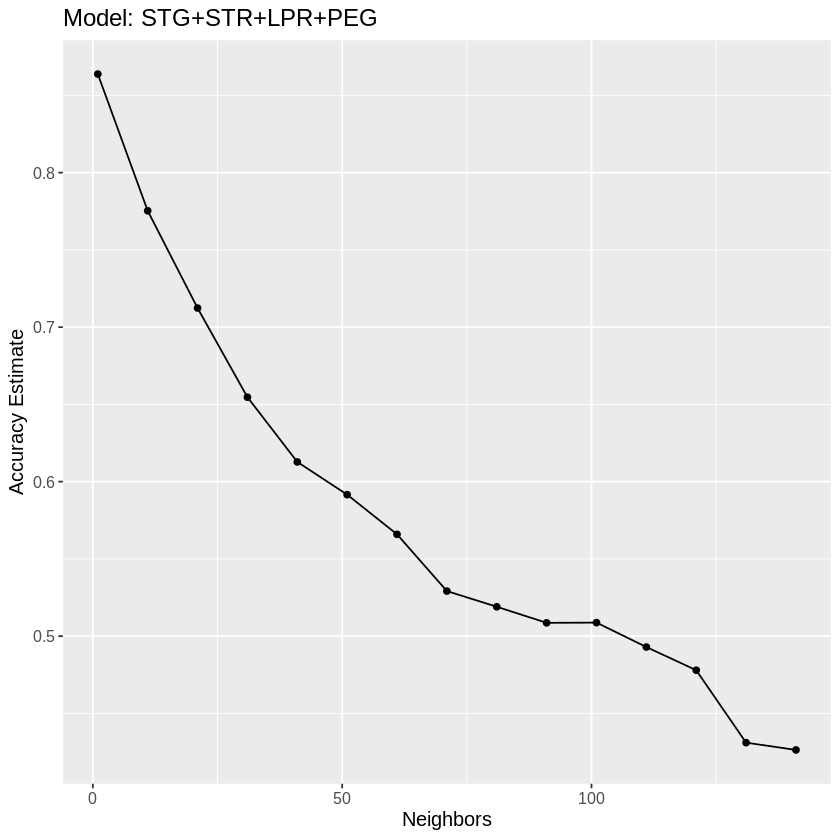

In [16]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "STG+STR+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 5, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 150, by = 10))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

! Fold07: internal:
  No observations were detected in `truth` for level(s): 'very_low'
  Computation will proceed by ignoring those levels.

! Fold10: internal:
  No observations were detected in `truth` for level(s): 'very_low'
  Computation will proceed by ignoring those levels.



[1] "Model: STG+STR+LPR+PEG"
[1] "Best K: 3"
[1] "Best accuracy: 0.880075187969925"


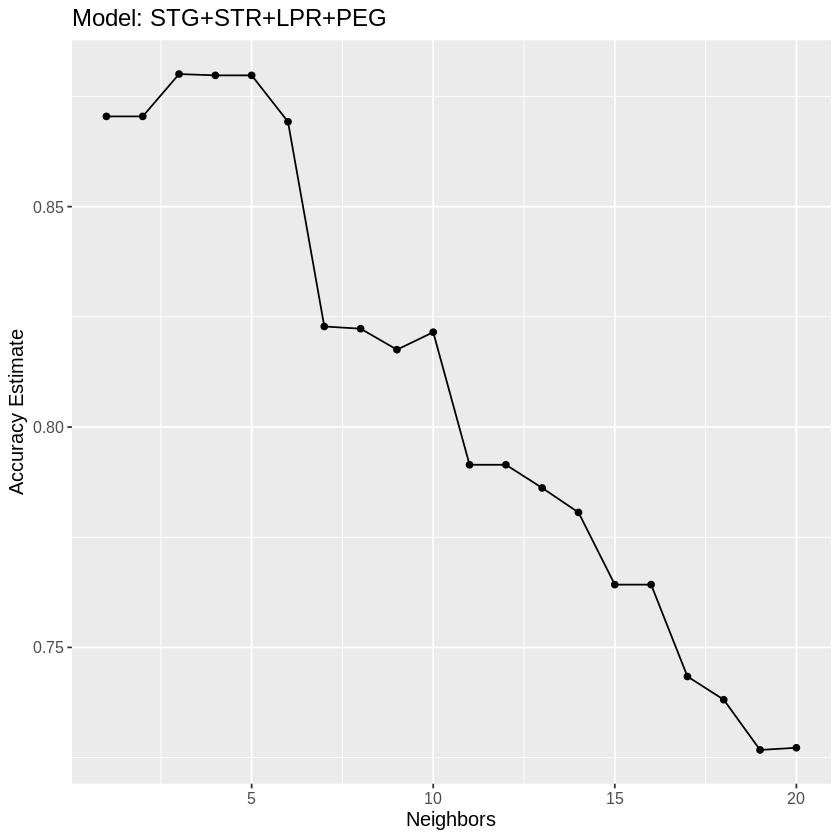

In [17]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "STG+STR+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 10, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

In [11]:
set.seed(9999)
# Classification: predicting UNS

data <- data |> 
    mutate(UNS = as.factor(UNS))

# Splitting the data
data_split <- initial_split(data, prop = 0.75, strata = UNS)
data_train <- training(data_split)
data_test <- testing(data_split)
              



# Train data
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
            set_engine("kknn") |>
            set_mode("classification")

data_recipe <- recipe(UNS ~ LPR + PEG, data = data_train) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())


data_fit <- workflow() |>
            add_model(knn_spec) |>
            add_recipe(data_recipe) |>
            fit(data = data_train)



# Predict the class labels for our test set
data_test_predictions <- predict(data_fit, data_test) |> bind_cols(data_test)

# Compute the classifier's accuracy
data_test_prediction_accuracy <- data_test_predictions |>
                            metrics(truth = "UNS", estimate = ".pred_class") |> 
                            filter(.metric == "accuracy")
print(data_test_prediction_accuracy)

# Table of predicted labels and correct labels
data_conf_mat <- conf_mat(data_test_predictions, truth = "UNS", estimate = ".pred_class")
print(data_conf_mat)

new_seed <- tibble(LPR = 0.5, PEG = 0.8)

prediction <- predict(data_fit, new_seed)
print(prediction)

# A tibble: 1 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy multiclass     0.955
          Truth
Prediction High Low Middle very_low
  High       16   0      0        0
  Low         0  21      2        1
  Middle      0   0     21        0
  very_low    0   0      0        5
# A tibble: 1 × 1
  .pred_class
  <fct>      
1 High       


## **Methods**

#### **Data Analysis Plan and Chosen Variables**

To predict the 'UNS' (User Knowledge Level), we'll adopt a systematic approach, beginning with calculating the pairwise correlation of all dataset variables. This will guide us in employing appropriate variables in a k-nearest neighbors model for 'UNS' prediction. We'll further apply a linear regression model using 'STG', 'SCG', 'STR', and 'LPR' to figure out the strongest relationship with 'PEG'.

#### **Visualization of Results**

For an intuitive visualization of our findings, we'll leverage the 'ggpairs' function from the 'GGally' R package. This will enable a scatterplot matrix construction, offering a detailed insight into variable relationships and interactions.

## **Expected Outcomes and Significance**

#### **Expected Findings**

We hypothesize that the variables we have chosen for our models significantly influence the user knowledge level, and consequently, anticipate that our predictive model will have a high degree of accuracy. Moreover, we postulate that the 'LPR' variable, representing the repetition number for the material, will exhibit the most potent influence on exam performance, represented by the 'PEG' variable.

#### **Implications of Findings**

The implications of our anticipated findings are multifold. Primarily, they can guide the development of effective study strategies for students. For instance, if a strong relationship is observed between 'LPR' and 'PEG', it could recommend an emphasis on repetitive learning of basic subject material.

#### **Future Research Questions**

Our study could pave the way for several interesting research questions, including:

- How can the web learning system be optimized to promote superior knowledge growth among users?
- Which metrics (e.g., repetition or study time) should be emphasized for improved learning outcomes?
- Which type of study material (e.g., goal-oriented or related materials) holds the most promise for academic achievement?


## **Reference**

Kahraman, H. T., Sagiroglu, S., & Colak, I. (2013). The development of intuitive knowledge classifier and the modeling of domain dependent data. Knowledge-Based Systems, 37, 283-295. https://doi.org/10.1016/j.knosys.2012.08.009


*need at least one more citation